# Part B:

In [ ]:
!unzip -q /content/dataset.zip -d /content/dataset

replace /content/dataset/dataset/accordion/image_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#importing all required libraries
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt

# Data Loading and splitting

In [ ]:
# Define the paths
extracted_path = '/content/dataset/dataset'
train_path = '/content/dataset/train'
test_path = '/content/dataset/test'

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Organize the dataset
categories = os.listdir(extracted_path)
for category in categories:
    category_full_path = os.path.join(extracted_path, category)
    if not os.path.isdir(category_full_path):
        continue

    # Create category directories in train and test folders
    os.makedirs(os.path.join(train_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_path, category), exist_ok=True)

    # Get all image files in the category
    images = sorted(os.listdir(category_full_path))

    # Split the images into train (0001 to 0040) and test sets
    train_images = images[:40]
    test_images = images[40:]

    # Move train images
    for image in train_images:
        src = os.path.join(category_full_path, image)
        dst = os.path.join(train_path, category, image)
        shutil.move(src, dst)

    # Move test images
    for image in test_images:
        src = os.path.join(category_full_path, image)
        dst = os.path.join(test_path, category, image)
        shutil.move(src, dst)

print("Dataset organized into training and testing sets.")


Dataset organized into training and testing sets.


# Data Augumentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 600 images belonging to 15 classes.
Found 205 images belonging to 15 classes.


# Fine Tuning VGG-19 Model

In [ ]:
# Define the base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(15, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the initial layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Initial training to update the top layers
model.fit(train_generator, validation_data=test_generator, epochs=10)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers as an example
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Custom callback to compute per-class precision and recall
class PerClassMetrics(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.metrics_df = pd.DataFrame()

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = [], []
        for i in range(len(self.validation_data)):
            batch = self.validation_data[i]
            val_x.append(batch[0])
            val_y.append(batch[1])
        val_x = np.concatenate(val_x, axis=0)
        val_y = np.concatenate(val_y, axis=0)

        val_pred = np.argmax(self.model.predict(val_x), axis=1)
        val_true = np.argmax(val_y, axis=1)

        precision = precision_score(val_true, val_pred, average=None, zero_division=0)
        recall = recall_score(val_true, val_pred, average=None, zero_division=0)

        # Create a temporary DataFrame to store the metrics
        temp_df = pd.DataFrame({
            'Precision': precision,
            'Recall': recall
        })
        temp_df['Epoch'] = epoch + 1
        temp_df['Class'] = range(len(precision))

        # Append the temporary DataFrame to the main DataFrame
        self.metrics_df = pd.concat([self.metrics_df, temp_df], ignore_index=True)

        for i in range(len(precision)):
            print(f'Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}')

# Fine-tuning the model
metrics_callback = PerClassMetrics(validation_data=test_generator)
model.fit(train_generator,
          validation_data=test_generator,
          epochs=10,
          callbacks=[metrics_callback])

# Plot the metrics
metrics_df = metrics_callback.metrics_df

Epoch 1/10
19/19 [==============================] - 12s 536ms/step - loss: 2.4348 - accuracy: 0.2550 - val_loss: 1.8163 - val_accuracy: 0.5659
Epoch 2/10
19/19 [==============================] - 10s 514ms/step - loss: 1.6406 - accuracy: 0.5883 - val_loss: 1.2547 - val_accuracy: 0.6488
Epoch 3/10
19/19 [==============================] - 12s 626ms/step - loss: 1.2917 - accuracy: 0.6083 - val_loss: 0.9795 - val_accuracy: 0.7122
Epoch 4/10
19/19 [==============================] - 10s 523ms/step - loss: 1.0133 - accuracy: 0.6950 - val_loss: 0.7396 - val_accuracy: 0.8049
Epoch 5/10
19/19 [==============================] - 11s 590ms/step - loss: 0.9123 - accuracy: 0.7183 - val_loss: 0.7008 - val_accuracy: 0.8195
Epoch 6/10
19/19 [==============================] - 9s 455ms/step - loss: 0.8049 - accuracy: 0.7467 - val_loss: 0.6591 - val_accuracy: 0.8146
Epoch 7/10
19/19 [==============================] - 12s 643ms/step - loss: 0.7306 - accuracy: 0.7683 - val_loss: 0.6090 - val_accuracy: 0.7951


In [ ]:
metrics_df

,Precision,Recall,Epoch,Class
0,1.000000,1.000000,1,0
1,0.875000,1.000000,1,1
2,0.833333,1.000000,1,2
3,1.000000,0.300000,1,3
4,0.450000,0.818182,1,4
...,...,...,...,...
145,0.933333,0.933333,10,10
146,0.866667,1.000000,10,11
147,1.000000,0.941176,10,12
148,0.866667,0.764706,10,13


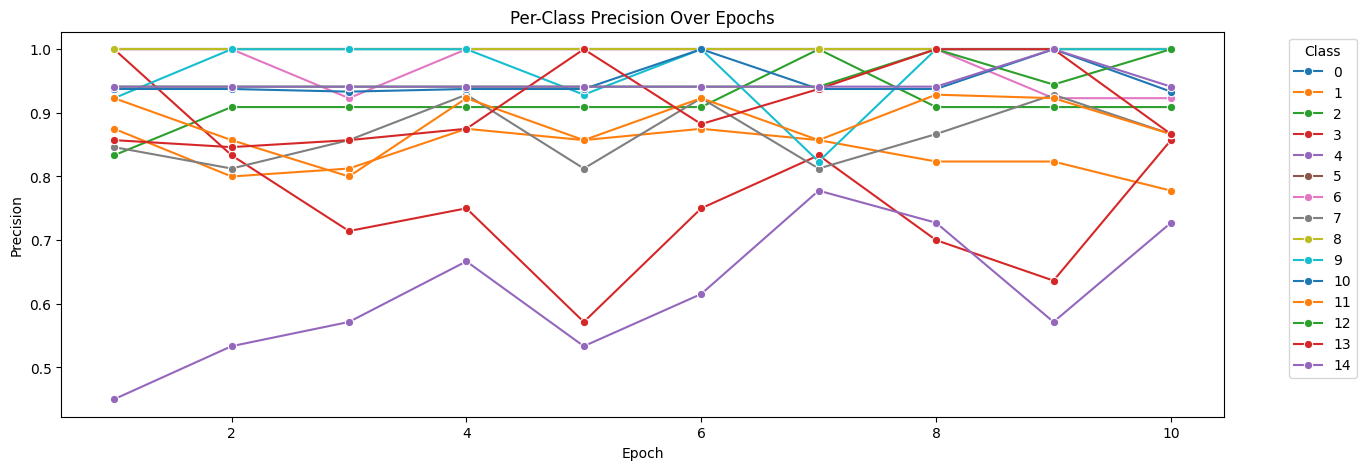

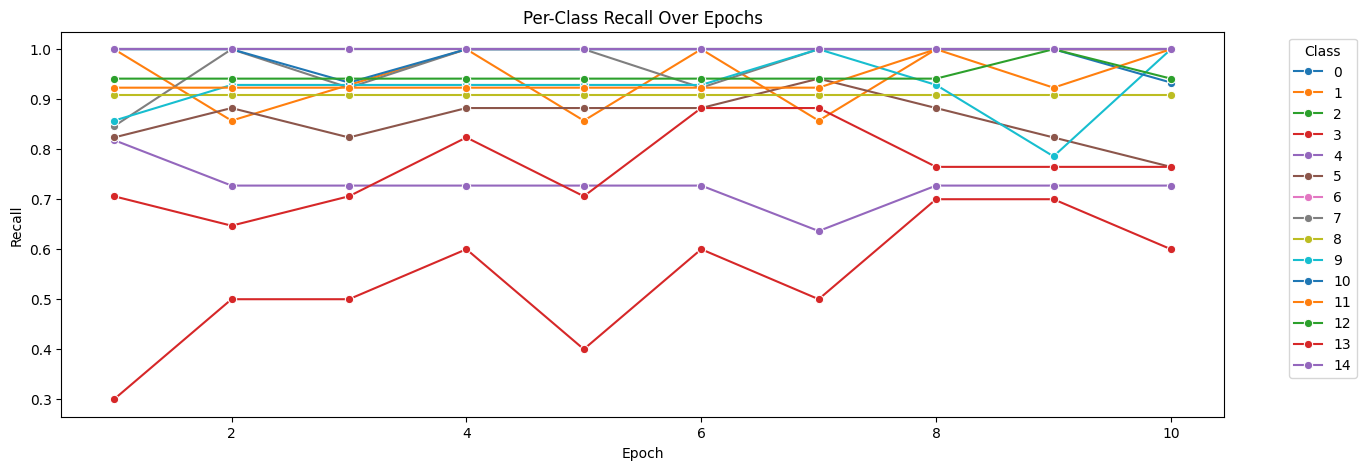

In [ ]:
import seaborn as sns
# Plotting the precision
plt.figure(figsize=(15, 5))
sns.lineplot(data=metrics_df, x='Epoch', y='Precision', hue='Class', palette='tab10', marker='o')
plt.title('Per-Class Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting the recall
plt.figure(figsize=(15, 5))
sns.lineplot(data=metrics_df, x='Epoch', y='Recall', hue='Class', palette='tab10', marker='o')
plt.title('Per-Class Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Evaluation on Test Images

In [ ]:
def predict_and_show_images(test_path, model, num_images=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_images):
        # Choose a random category
        category = random.choice(os.listdir(test_path))
        category_path = os.path.join(test_path, category)

        # Choose a random image file from that category
        image_file = random.choice(os.listdir(category_path))
        image_path = os.path.join(category_path, image_file)

        # Load and preprocess the image
        image = load_img(image_path, target_size=(224, 224))
        image_array = img_to_array(image)
        image_array = image_array / 255.0  # Rescale as done in the ImageDataGenerator
        image_array = np.expand_dims(image_array, axis=0)  # Expand dims to fit model input

        # Predict the image
        predictions = model.predict(image_array)
        predicted_class = np.argmax(predictions, axis=1)

        # Retrieve the actual label (the category)
        actual_label = category

        # Find predicted label name from class index
        labels = (train_generator.class_indices)
        labels = dict((v, k) for k, v in labels.items())
        predicted_label = labels[predicted_class[0]]

        # Plotting
        ax = axes[i]
        ax.imshow(np.squeeze(image))
        ax.set_title(f"Pred: {predicted_label}\nActual: {actual_label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 20ms/step


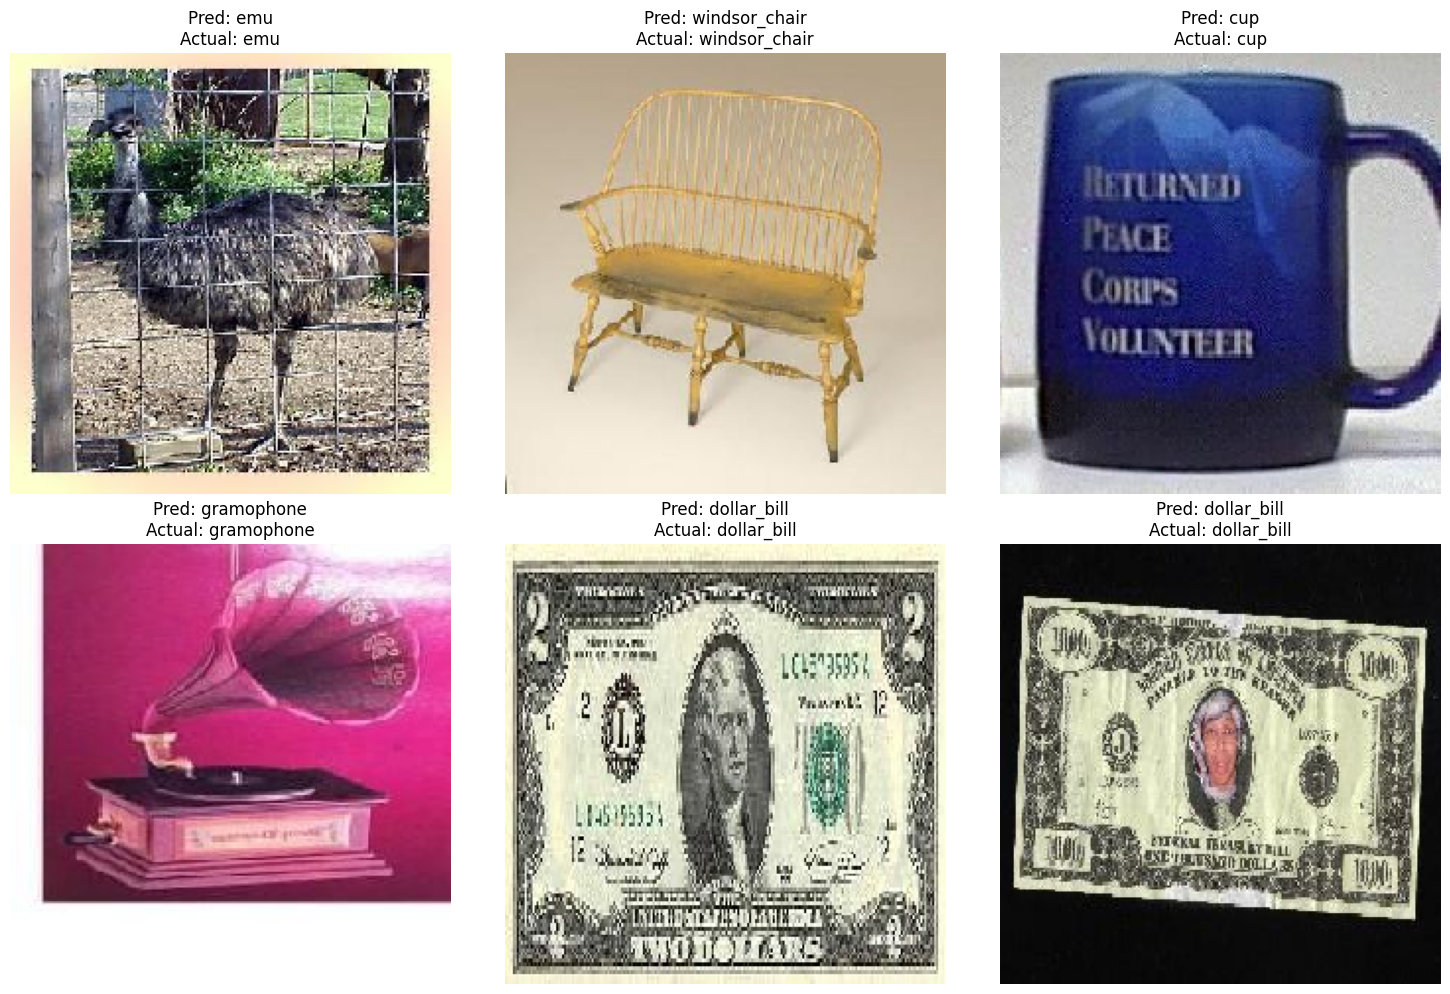

In [ ]:
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
predict_and_show_images(test_path, model)

The model's accuracy improved from 25.5% to 92.67%, and validation accuracy peaked at 92.20%, indicating strong generalization. Training loss decreased from 2.4348 to 0.2508, with validation loss dropping from 1.8163 to 0.2810, showing effective learning. Most classes had high precision and recall, indicating reliable performance, but classes 3, 4, and 13 showed variability, suggesting the need for further data or fine-tuning to improve performance on these classes.